In [ ]:
import tensorflow as tf
import os
import zipfile

# URL do dataset Cats and Dogs
url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"

# Fazer o download e salvar no diretório local
dataset_path = tf.keras.utils.get_file("cats_and_dogs_filtered.zip", origin=url, extract=True)

# Caminho do diretório extraído
dataset_dir = os.path.join(os.path.dirname(dataset_path), 'cats_and_dogs_filtered')

print(f"Dataset extraído em: {dataset_dir}")

# Listar o conteúdo
print(os.listdir(dataset_dir))


Dataset extraído em: /root/.keras/datasets/cats_and_dogs_filtered
['vectorize.py', 'validation', 'train']


In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'validation')

print("Conteúdo da pasta de treinamento:", os.listdir(train_dir))
print("Conteúdo da pasta de validação:", os.listdir(validation_dir))

Conteúdo da pasta de treinamento: ['dogs', 'cats']
Conteúdo da pasta de validação: ['dogs', 'cats']


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normaliza os dados
train_datagen = ImageDataGenerator(rescale=1.0/255)
validation_datagen = ImageDataGenerator(rescale=1.0/255)

# Gerar os dados para treinamento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Redimensionar as imagens
    batch_size=32,
    class_mode='binary'  # Para classificação binária
)

# Gera os dados para validação
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=20)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Carrega o modelo InceptionV3 pré-treinado sem as camadas densas finais
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Congela as camadas do modelo base para não atualizá-las durante o treinamento inicial
base_model.trainable = False

# Adiciona as camadas personalizadas no topo
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Reduz as dimensões para 1 por filtro
    layers.Dense(128, activation='relu'),  # Camada densa com 128 unidades
    layers.Dropout(0.3),  # Regularização para evitar overfitting
    layers.Dense(1, activation='sigmoid')  # Saída binária
])

# Compila o modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Visualiza o resumo do modelo
model.summary()


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 3, 3, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,065,185 (84.17 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=5,  # Define a quantia de epocas de treinamento
    validation_data=validation_generator,
    validation_steps=50
)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 63/100 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8040 - loss: 0.6139

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.8327 - loss: 0.5094 - val_accuracy: 0.9560 - val_loss: 0.1020
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.9520 - loss: 0.1227 - val_accuracy: 0.9460 - val_loss: 0.1362
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.9436 - loss: 0.1423 - val_accuracy: 0.9560 - val_loss: 0.0963
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.9554 - loss: 0.1170 - val_accuracy: 0.9620 - val_loss: 0.0906
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9539 - loss: 0.1105 - val_accuracy: 0.9580 - val_loss: 0.1057


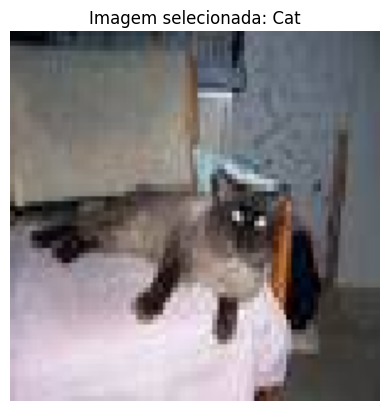

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Predição: Cat (Confiança: 0.72)


In [ ]:
import os
import random
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Diretórios do dataset
dataset_dir = os.path.join(os.path.dirname(tf.keras.utils.get_file(
    "cats_and_dogs_filtered.zip",
    origin="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip",
    extract=True)), 'cats_and_dogs_filtered')

train_dir = os.path.join(dataset_dir, 'train')  # Diretório de treino
validation_dir = os.path.join(dataset_dir, 'validation')  # Diretório de validação

# Escolhe aleatoriamente entre gatos e cachorros
category = random.choice(['cats', 'dogs'])
selected_dir = os.path.join(train_dir, category)

# Escolhe uma imagem aleatória
selected_image = random.choice(os.listdir(selected_dir))
image_path = os.path.join(selected_dir, selected_image)

# Carrega a imagem
img = load_img(image_path, target_size=(150, 150))  # Redimensiona para 150x150
plt.imshow(img)
plt.title(f"Imagem selecionada: {category[:-1].capitalize()}")
plt.axis('off')
plt.show()

# Processa a imagem para o modelo
img_array = img_to_array(img) / 255.0  # Normaliza os valores dos pixels
img_array = np.expand_dims(img_array, axis=0)  # Expandir para formato de batch

# Fazer a predição
prediction = model.predict(img_array)
predicted_label = "Dog" if prediction[0] > 0.5 else "Cat"
confidence = prediction[0][0] if prediction[0] > 0.5 else 1 - prediction[0][0]

# Exibir o resultado
print(f"Predição: {predicted_label} (Confiança: {confidence:.2f})")


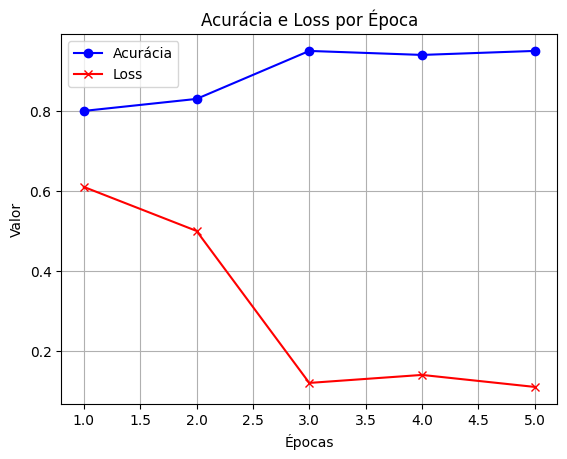

In [ ]:
import matplotlib.pyplot as plt

# dados do treinamento do modelo
epochs = [1, 2, 3, 4, 5]
accuracy = [0.80, 0.83, 0.95, 0.94, 0.95]
loss = [0.61, 0.50, 0.12, 0.14, 0.11]

# Cria o gráfico
plt.plot(epochs, accuracy, label='Acurácia', color='blue', linestyle='-', marker='o')
plt.plot(epochs, loss, label='Loss', color='red', linestyle='-', marker='x')

# Adiciona título e rótulos
plt.title('Acurácia e Loss por Época')
plt.xlabel('Épocas')
plt.ylabel('Valor')

# Adiciona a legenda
plt.legend()

# Exibi o gráfico
plt.grid(True)
plt.show()